In [ ]:
!pip install ultralytics
!pip install opencv-python
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 105.1 MB/s eta 0:00:00


In [ ]:
# =========================================
# YOLOv8 OBB Vessel Detection on Pleiades
# =========================================

import os, math, shutil
import cv2
import numpy as np
from ultralytics import YOLO
from osgeo import gdal
import csv
import rasterio
import torch


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

CUDA available: True
Device name: Tesla T4


In [ ]:
from google.colab import files

# Upload YOLO model
uploaded_file = files.upload()  # Select yolov8m-obb.pt

Saving satellite_image_21.png to satellite_image_21.png


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# Example paths
INPUT_IMAGE = "/content/drive/MyDrive/Pleiades ESA Archive/cropped_pleiades_dominica.tif"

In [ ]:
# ------------------------------------------------
# User settings - edit these
# ------------------------------------------------
MODEL_PATH = "best.pt"   # path in Drive
INPUT_IMAGE = "/content/drive/MyDrive/Pleiades ESA Archive/cropped_pleiades_dominica.tif"
OUTPUT_DIR = "/content/drive/MyDrive/Pleiades_Detections_trial2"   # save directly to Drive
TILE_SIZE = 640
CONF_THRESHOLD = 0.20   # try lower if 0 detections
IOU_THRESHOLD = 0.45
TRAINING_RES_MPP = 0.3  # Google Maps zoom 19 ~0.3 m/pixel
TILE_OVERLAP = 64       # overlap in px to avoid cutting objects at borders (set 0 to disable)
SAVE_DEBUG_TILES = True # saves first N tiles for manual check
DEBUG_TILES_N = 6
TILES_DIR = "all_tiles"
PREDICTIONS_DIR = "tile_detections"
CSV_FILE = "detections.csv"

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(TILES_DIR, exist_ok=True)
os.makedirs(PREDICTIONS_DIR, exist_ok=True)

In [ ]:
# -----------------------------
# 1. Open Pleiades JP2
# -----------------------------
with rasterio.open(INPUT_IMAGE) as src:
    img16 = src.read([1, 2, 3])  # RGB
    img16 = np.transpose(img16, (1, 2, 0))  # HWC
    transform = src.transform
    pleiades_res_mpp_x = transform.a
    pleiades_res_mpp_y = abs(transform.e)
    print(f"Pleiades pixel size: {pleiades_res_mpp_x} m")


Pleiades pixel size: 0.5 m


In [ ]:
# -----------------------------
# 2. Convert 16-bit image to 8-bit
# -----------------------------
def uint16_to_uint8(img16, pmin=1, pmax=99.5):
    """
    Contrast stretch each band from 16-bit -> 8-bit using percentiles.
    """
    img8 = np.empty_like(img16, dtype=np.uint8)
    for b in range(img16.shape[2]):
        band = img16[..., b].astype(np.float32)
        lo = np.percentile(band, pmin)
        hi = np.percentile(band, pmax)
        if hi - lo <= 0:
            hi = band.max() if band.max() > 0 else lo + 1
        band = np.clip((band - lo) / (hi - lo), 0.0, 1.0)
        img8[..., b] = (band * 255).astype(np.uint8)
    return img8

img_uint8 = uint16_to_uint8(img16)
print(f"Converted to uint8: {img_uint8.shape}")

Converted to uint8: (13002, 4813, 3)


In [ ]:
# Upscale Pleiades to match training GSD
scale_factor = pleiades_res_mpp_x / TRAINING_RES_MPP  # 0.5 / 0.3 ≈ 1.667

new_width  = int(img_uint8.shape[1] * scale_factor)
new_height = int(img_uint8.shape[0] * scale_factor)

img_rescaled = cv2.resize(img_uint8, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
print(f"Rescaled image shape: {img_rescaled.shape}")


Rescaled image shape: (21670, 8021, 3)


In [ ]:
tiles = []
coords = []      # keep track of tile offsets
tile_offsets_dict = {}  # save offsets to a file

h, w, _ = img_rescaled.shape

for y in range(0, h, TILE_SIZE):
    for x in range(0, w, TILE_SIZE):
        tile = img_rescaled[y:y+TILE_SIZE, x:x+TILE_SIZE]

        # pad edges if smaller than TILE_SIZE
        if tile.shape[0] != TILE_SIZE or tile.shape[1] != TILE_SIZE:
            tile_padded = np.zeros((TILE_SIZE, TILE_SIZE, 3), dtype=np.uint8)
            tile_padded[:tile.shape[0], :tile.shape[1], :] = tile
            tile = tile_padded

        # skip completely black tiles
        if np.all(tile == 0):
            continue

        tiles.append(tile)
        coords.append((x, y))

        tile_filename = f"tile_{len(tiles):04d}.png"
        cv2.imwrite(os.path.join(TILES_DIR, tile_filename), cv2.cvtColor(tile, cv2.COLOR_RGB2BGR))

        # save offset
        tile_offsets_dict[tile_filename] = (x, y)

# Save offsets to file for later use
import json
with open(os.path.join(TILES_DIR, "tile_offsets.json"), "w") as f:
    json.dump(tile_offsets_dict, f)


In [ ]:
# -----------------------------
# 4. Run YOLOv8 OBB detection on folder
# -----------------------------
model = YOLO(MODEL_PATH, task="obb")
all_detections = []

results = model.predict(
    source=TILES_DIR,         # folder of saved tiles
    imgsz=TILE_SIZE,
    conf=CONF_THRESHOLD,
    iou=IOU_THRESHOLD,
    task="obb",
    save=True,                # saves annotated images in project/name
    save_txt=True,            # saves bounding boxes as txt files
    save_conf=True,
    project=PREDICTIONS_DIR,
    name="predictions"
)


image 1/132 /content/all_tiles/tile_0001.png: 640x640 (no detections), 38.4ms
image 2/132 /content/all_tiles/tile_0002.png: 640x640 3 fishing-vesselss, 47.5ms
image 3/132 /content/all_tiles/tile_0003.png: 640x640 (no detections), 45.5ms
image 4/132 /content/all_tiles/tile_0004.png: 640x640 (no detections), 41.3ms
image 5/132 /content/all_tiles/tile_0005.png: 640x640 2 fishing-vesselss, 38.5ms
image 6/132 /content/all_tiles/tile_0006.png: 640x640 1 fishing-vessels, 42.1ms
image 7/132 /content/all_tiles/tile_0007.png: 640x640 (no detections), 41.1ms
image 8/132 /content/all_tiles/tile_0008.png: 640x640 (no detections), 48.4ms
image 9/132 /content/all_tiles/tile_0009.png: 640x640 (no detections), 30.1ms
image 10/132 /content/all_tiles/tile_0010.png: 640x640 (no detections), 30.1ms
image 11/132 /content/all_tiles/tile_0011.png: 640x640 (no detections), 30.0ms
image 12/132 /content/all_tiles/tile_0012.png: 640x640 1 fishing-vessels, 30.0ms
image 13/132 /content/all_tiles/tile_0013.png: 640

In [ ]:
import os
import json
import numpy as np
import cv2
from shapely.geometry import Polygon, mapping
import geopandas as gpd
import rasterio

# -----------------------------
# Parameters
# -----------------------------
TILES_DIR = "/content/all_tiles"                        # folder with rescaled tiles
LABELS_DIR = "/content/tile_detections/predictions/labels"
OFFSETS_FILE = os.path.join(TILES_DIR, "tile_offsets.json")
INPUT_IMAGE = "/content/drive/MyDrive/Pleiades ESA Archive/cropped_pleiades_dominica.tif"
OUTPUT_GEOJSON = "/content/detections_corrected.geojson"

# Pixel size of Pleiades and YOLO training GSD (meters/pixel)
TRAINING_RES_MPP = 0.3
with rasterio.open(INPUT_IMAGE) as src:
    pleiades_res_mpp_x = src.transform.a

scale_factor = pleiades_res_mpp_x / TRAINING_RES_MPP  # e.g., 0.5 / 0.3 ≈ 1.667

# Class mapping
CLASS_NAMES = {0: "catamaran", 1: "fishing-vessels", 2: "other_vessel", 3: "private_yachts", 4: "recreational boat"}

# -----------------------------
# Load raster info
# -----------------------------
with rasterio.open(INPUT_IMAGE) as src:
    transform = src.transform
    crs = src.crs

# -----------------------------
# Load tile offsets
# -----------------------------
with open(OFFSETS_FILE, "r") as f:
    tile_offsets = json.load(f)

# -----------------------------
# Convert YOLO OBB predictions to polygons
# -----------------------------
all_features = []

for label_file in os.listdir(LABELS_DIR):
    if not label_file.endswith(".txt"):
        continue

    tile_name = label_file.replace(".txt", ".png")
    if tile_name not in tile_offsets:
        continue

    x_off_rescaled, y_off_rescaled = tile_offsets[tile_name]

    # Load actual tile to get its dimensions
    tile_img = cv2.imread(os.path.join(TILES_DIR, tile_name))
    tile_h, tile_w = tile_img.shape[:2]

    # Read YOLO label
    with open(os.path.join(LABELS_DIR, label_file), "r") as f:
        for line in f:
            vals = list(map(float, line.strip().split()))
            cls = int(vals[0])
            class_name = CLASS_NAMES.get(cls, "unknown")
            conf = vals[-1] if len(vals) > 9 else 1.0

            # Normalized coordinates from YOLO OBB: x1 y1 ... x4 y4
            coords_norm = np.array(vals[1:9]).reshape(4,2)

            # Rescaled tile pixel coordinates
            coords_rescaled = coords_norm * np.array([tile_w, tile_h])

            # Full image rescaled pixels
            coords_rescaled_full = coords_rescaled + np.array([x_off_rescaled, y_off_rescaled])

            # Convert to original image pixels
            coords_orig = coords_rescaled_full / scale_factor

            # Map to georeferenced coordinates
            pts_world = []
            for px, py in coords_orig:
                x_map = transform.c + px * transform.a + py * transform.b
                y_map = transform.f + px * transform.d + py * transform.e
                pts_world.append((x_map, y_map))

            poly = Polygon(pts_world)
            centroid = poly.centroid

            all_features.append({
                "type": "Feature",
                "geometry": mapping(poly),
                "properties": {
                    "class": cls,
                    "class_name": class_name,
                    "conf": conf,
                    "tile": tile_name,
                    "centroid_x": centroid.x,
                    "centroid_y": centroid.y
                }
            })

# -----------------------------
# Save GeoJSON
# -----------------------------
gdf = gpd.GeoDataFrame.from_features(all_features, crs=crs)
gdf.to_file(OUTPUT_GEOJSON, driver="GeoJSON")

print(f"Saved {len(all_features)} detections to {OUTPUT_GEOJSON}")


Saved 110 detections to /content/detections_corrected.geojson


In [ ]:
import shutil
from google.colab import files
import os

# Path to your predictions folder
PREDICTIONS_DIR = "/content/tile_detections/predictions"

# Path for the zip file
ZIP_PATH = "/content/predictions.zip"

# Create zip
shutil.make_archive(base_name=ZIP_PATH.replace(".zip", ""), format='zip', root_dir=PREDICTIONS_DIR)

# Download
files.download(ZIP_PATH)


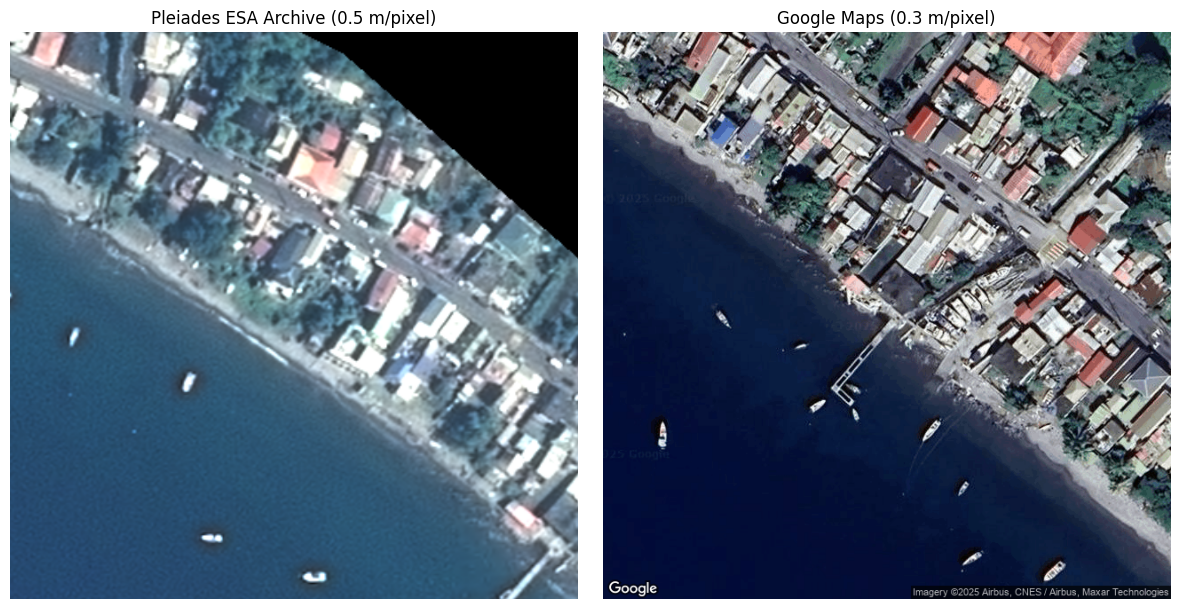

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Paths to your images
pleiades_path = "/content/all_tiles/tile_0125.png"
google_map_path = "/content/satellite_image_21.png"  # 0.3 m/pixel

# Load images
pleiades_img = cv2.imread(pleiades_path, cv2.IMREAD_COLOR)
pleiades_img = cv2.cvtColor(pleiades_img, cv2.COLOR_BGR2RGB)

google_img = cv2.imread(google_map_path, cv2.IMREAD_COLOR)
google_img = cv2.cvtColor(google_img, cv2.COLOR_BGR2RGB)

# Optional: resize images to same display size for comparison
height = min(pleiades_img.shape[0], google_img.shape[0])
width  = min(pleiades_img.shape[1], google_img.shape[1])

pleiades_img_resized = cv2.resize(pleiades_img, (width, height), interpolation=cv2.INTER_LINEAR)
google_img_resized   = cv2.resize(google_img, (width, height), interpolation=cv2.INTER_LINEAR)

# Display side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(pleiades_img_resized)
plt.title("Pleiades ESA Archive (0.5 m/pixel)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(google_img_resized)
plt.title("Google Maps (0.3 m/pixel)")
plt.axis("off")

plt.tight_layout()
plt.show()
